In [1]:
import torch
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None) 

In [2]:
from analysis_utils import determine_significant_explanation, load_and_fix_json_files, show_histogram, chunk_data, filter_chunked_data, session_to_positions, session_to_values, shorten_list_in_json, show_double_bar_chart
from model import trans_to_cuda

In [3]:
directory = "./explanation_files_long_training_rerun"
json_data = load_and_fix_json_files(directory, exclude_latest_file=True)
json_data_modify_session_embeddings = load_and_fix_json_files("./explanation_files_long_training_rerun_modify_session_embeddings", exclude_latest_file=True)
len(json_data) // 3, len(json_data_modify_session_embeddings) // 3

(1000, 1000)

In [4]:
bigrams = torch.load("bigram_matrix_yoochoose.pth")
bigrams = bigrams.to_dense()

/tmp/ipykernel_2613915/3535501569.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bigrams = torch.load("bigram_matrix_yoochoose.pth")


In [5]:
ranking = torch.load("vertex_ranking.pt")
non_zero_values = ranking[ranking[:, 0] != 0]
ranking.shape, ranking[:,0].mean().item(), ranking[:, 0].median().item()

/tmp/ipykernel_2613915/2553819950.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ranking = torch.load("vertex_ranking.pt")


(torch.Size([16191, 2]), 114.40584564208984, 16.0)

In [6]:
def find_the_most_suggested_vertex(e):
    if not e["best_vertex"]["in_session"]:
        return e["best_vertex"]["id"], e["best_vertex"]["value"]
    for i, v in enumerate(e["values"]):
        if e["indices"][i] not in e["session"] and e["indices"][i] != e["target"]:
            return e["indices"][i], v
    return None, None

In [7]:
def stability_analysis(chunked_data):
    deterministic_score = 0
    stability_score = 0
    for chunk in chunked_data:
        e1, e2, e3 = chunk
        real_best_vertex_id_e1, _ = find_the_most_suggested_vertex(e1)
        real_best_vertex_id_e2, _ = find_the_most_suggested_vertex(e2)
        real_best_vertex_id_e3, _ = find_the_most_suggested_vertex(e3)
        if real_best_vertex_id_e1 == real_best_vertex_id_e2:
            deterministic_score += 1
        if real_best_vertex_id_e1 == real_best_vertex_id_e2 == real_best_vertex_id_e3:
            stability_score += 1
    return deterministic_score / len(chunked_data), stability_score / len(chunked_data)

In [8]:
def common_vertices(chunked_data, k = 10):
    cv = 0
    for chunk in chunked_data:
        e1, e2, _ = chunk
        l1 = [x for x in e1["indices"] if x != e1["target"] and x not in e1["session"]][:k]
        l2 = [x for x in e2["indices"] if x != e2["target"] and x not in e2["session"]][:k]
        cv += len(set(l1).intersection(set(l2)))
    return (cv / len(chunked_data)) / k

In [9]:
def ranking_lookup(node_ids):
    node_id_column = ranking[:, 1].long()
    positions = torch.nonzero(node_id_column.unsqueeze(0) == node_ids.unsqueeze(1), as_tuple=True)[1]
    values = ranking[positions, 0]
    return positions, values

In [10]:
def ranking_analysis(chunked_data, se = False):
    ranking_pos = 0
    ranking_value = 0
    total_num = 0
    for chunk in chunked_data:
        ex, _, _ = chunk
        real_best_vertex_id = find_the_most_suggested_vertex(ex)[0] if not se else determine_significant_explanation(ex)
        if not se:
            pos, val = ranking_lookup(trans_to_cuda(torch.Tensor([real_best_vertex_id])))
        else:
            rl = ranking_lookup(trans_to_cuda(real_best_vertex_id))
            pos = rl[0]
            val = rl[1]
            if len(pos) == 0:
                continue
        ranking_pos += pos.item() if not se else pos.float().mean().item()
        ranking_value += val.item() if not se else val.mean().item()
        if not (se and len(real_best_vertex_id) == 0):
            total_num += 1
    average_ranking_pos = ranking_pos / total_num
    average_ranking_value = ranking_value / total_num
    return average_ranking_pos, average_ranking_value

In [11]:
def uniqueness_analysis(chunked_data):
    best_vertices = []
    for chunk in chunked_data:
        ex, _, _ = chunk
        real_best_vertex_id, _ = find_the_most_suggested_vertex(ex)
        best_vertices.append(real_best_vertex_id)
    return len(set(best_vertices)) / len(best_vertices)

In [12]:
def most_suggested_vertices(chunked_data):
    count = torch.zeros(bigrams.shape[0])
    for chunk in chunked_data:
        ex, _, _ = chunk
        real_best_vertex_id, _ = find_the_most_suggested_vertex(ex)
        count[real_best_vertex_id] += 1
    sorted_count, indices = torch.sort(trans_to_cuda(torch.Tensor(count)), descending=True)
    return torch.stack((sorted_count, indices), dim=1)

In [13]:
def most_suggested_vertices_se(chunked_data):
    count = torch.zeros(bigrams.shape[0])
    for chunk in chunked_data:
        ex, _, _ = chunk
        se = determine_significant_explanation(ex)
        for v in se:
            count[int(v.item())] += 1
    sorted_count, indices = torch.sort(trans_to_cuda(torch.Tensor(count)), descending=True)
    return torch.stack((sorted_count, indices), dim=1)

In [14]:
def common_vertices_se(chunked_data, threshold=0.05, triple = False):
    cv = 0
    c = 0
    for chunk in chunked_data:
        e1, e2, e3 = chunk
        l1 = determine_significant_explanation(e1, threshold=threshold).tolist()
        l2 = determine_significant_explanation(e2, threshold=threshold).tolist()
        if triple:
            l3 = determine_significant_explanation(e3, threshold=threshold).tolist()
            if len(l1) == 0 or len(l2) == 0 or len(l3) == 0:
                continue
            c += 1 
            cv += len(set(l1).intersection(set(l2)).intersection(set(l3))) / len(set(l1).union(set(l2)).union(set(l3)))
        else:
            if len(l1) == 0 or len(l2) == 0:
                continue
            c += 1 
            cv += len(set(l1).intersection(set(l2))) / len(set(l1).union(set(l2)))
    return cv / c if c != 0 else 0

In [15]:
def top_5_vertices_analysis(chunked_data, se = False):
    most_suggested_vs = most_suggested_vertices(chunked_data) if not se else most_suggested_vertices_se(chunked_data)
    most_suggested_vertices_small = most_suggested_vs[most_suggested_vs[:, 0] > 0.5].int()[:5]
    most_suggested_vertices_small_with_percentage = torch.cat((most_suggested_vertices_small, (most_suggested_vertices_small[:, 0] / (most_suggested_vs)[:, 0].sum()).unsqueeze(1)), dim=1)
    top_5_vertices = [(int(row[1]), round(row[2].item(), 2)) for row in most_suggested_vertices_small_with_percentage.cpu()]
    top_5_vertices_ids = [vertex[0] for vertex in top_5_vertices]
    top_t_vertices_ranking_positions, _ = ranking_lookup(trans_to_cuda(torch.tensor(top_5_vertices_ids)))
    return top_5_vertices, top_t_vertices_ranking_positions.cpu().tolist(), most_suggested_vertices_small_with_percentage[:, 2].sum(). item()

In [16]:
def bigram_analysis(chunked_data, fake_target=False):
    vertex_sum = 0
    all_vertices_no = 0
    pos_vertices_no = 0
    pos_sessions_no = 0
    for chunk in chunked_data:
        ex, _, _ = chunk
        the_most_suggested_vertex = find_the_most_suggested_vertex(ex)[0] if not fake_target else torch.randint(low=0, high=bigrams.shape[0], size=(1,)).item()
        session_sum = 0
        for idx in ex["session"]:
            current_sum = bigrams[the_most_suggested_vertex, idx].item() + bigrams[idx, the_most_suggested_vertex].item()
            vertex_sum += current_sum
            session_sum += current_sum
            if current_sum > 0:
                pos_vertices_no += 1
            all_vertices_no += 1
        if session_sum > 0:
            pos_sessions_no += 1
    return vertex_sum / all_vertices_no, vertex_sum / len(chunked_data), pos_vertices_no / all_vertices_no, pos_sessions_no / len(chunked_data)


In [17]:
def bigram_analysis_se(chunked_data, fake_target=False, session_threshold=0.5):
    vertex_sum = 0
    all_vertices_no = 0
    pos_vertices_no = 0
    session_sums = []
    positive_sessions = []
    for chunk in chunked_data:
        ex, _, _ = chunk
        se = determine_significant_explanation(ex)
        if len(se) == 0:
            continue
        if fake_target:
            se = torch.randint(low=0, high=bigrams.shape[0], size=(len(se),)).tolist()
        positivity_se = 0
        for v in se:
            v = int(v)
            session_sum = 0
            for idx in ex["session"]:
                current_sum = bigrams[v, idx].item() + bigrams[idx, v].item()
                vertex_sum += current_sum
                session_sum += current_sum
                if current_sum > 0:
                    pos_vertices_no += 1
                all_vertices_no += 1
            session_sums.append(session_sum)
            if session_sum > 0:
                positivity_se += 1
        positive_sessions.append(positivity_se / len(se))
    return vertex_sum / all_vertices_no, sum(session_sums) / len(session_sums), pos_vertices_no / all_vertices_no, len([x for x in positive_sessions if x >= session_threshold]) / len(positive_sessions)

In [18]:
def all_metrics_values(chunked_data, name, threshold = 0.05):
    deterministic_score, stability_score = stability_analysis(chunked_data)
    common_vertices_count = common_vertices(chunked_data)
    average_weight_per_vertex, average_weight_per_session, positive_vertices, positive_sessions = bigram_analysis(chunked_data)
    average_weight_per_vertex_fake, average_weight_per_session_fake, positive_vertices_fake, positive_sessions_fake = bigram_analysis(chunked_data, fake_target=True)
    average_ranking_pos, average_ranking_value = ranking_analysis(chunked_data)
    uniqueness = uniqueness_analysis(chunked_data)
    top_5_vertices, top_t_vertices_ranking_positions, top_5_vertices_cumulative_percentage = top_5_vertices_analysis(chunked_data)
    significant_explanation = [determine_significant_explanation(e, threshold) for e, _, _ in chunked_data]
    significant_explanation_lens = torch.Tensor([len(se) for se in significant_explanation])
    se_weight_per_vertex, se_weight_per_session, se_positive_vertices, se_positive_sessions = bigram_analysis_se(chunked_data)
    se_weight_per_vertex_fake, se_weight_per_session_fake, se_positive_vertices_fake, se_positive_sessions_fake = bigram_analysis_se(chunked_data,fake_target=True)
    se_average_ranking_pos, se_average_ranking_value = ranking_analysis(chunked_data, se=True)
    top_5_vertices_se, top_t_vertices_ranking_positions_se, top_5_vertices_cumulative_percentage_se = top_5_vertices_analysis(chunked_data, se=True)
    relevance_rounding = 3
    other_rounding = 3
    return {
        "name" : name,
        "modify_global_embedding": chunked_data[0][0]["modify_global_embedding"],
        "no_of_sessions": len(chunked_data),
        "deterministic_score": round(deterministic_score, 2),
        "stability_score": round(stability_score, 2),
        "common_vertices": round(common_vertices_count, 2),
        "average_weight_per_vertex": round(average_weight_per_vertex, relevance_rounding),
        "average_weight_per_vertex_fake": round(average_weight_per_vertex_fake, relevance_rounding),
        "average_weight_per_session": round(average_weight_per_session, relevance_rounding),
        "average_weight_per_session_fake": round(average_weight_per_session_fake, relevance_rounding),
        "positive_vertices": round(positive_vertices, relevance_rounding),
        "positive_vertices_fake": round(positive_vertices_fake, relevance_rounding),
        "positive_sessions": round(positive_sessions, relevance_rounding),
        "positive_sessions_fake": round(positive_sessions_fake, relevance_rounding),
        "average_ranking_pos": int(round(average_ranking_pos, 0)),
        "average_ranking_value": round(average_ranking_value, other_rounding),
        "uniqueness": round(uniqueness, other_rounding),
        "top_5_most_suggested_vertices": top_5_vertices,
        "top_5_most_suggested_vertices_ranking_positions": top_t_vertices_ranking_positions,
        "top_5_vertices_cumulative_percentage": round(top_5_vertices_cumulative_percentage, other_rounding),
        "se_percentage": round(len(significant_explanation_lens[significant_explanation_lens > 0]) / len(significant_explanation_lens), 2),
        "se_lengths": round(significant_explanation_lens[significant_explanation_lens > 0].mean().item(), 2),
        "se_common_vertices_double": round(common_vertices_se(chunked_data, threshold), 2),
        "se_common_vertices_triple": round(common_vertices_se(chunked_data, threshold, triple=True), 2),
        "se_average_weight_per_vertex": round(se_weight_per_vertex, relevance_rounding),
        "se_average_weight_per_vertex_fake": round(se_weight_per_vertex_fake, relevance_rounding),
        "se_average_weight_per_session": round(se_weight_per_session, relevance_rounding),
        "se_average_weight_per_session_fake": round(se_weight_per_session_fake, relevance_rounding),
        "se_positive_vertices": round(se_positive_vertices, relevance_rounding),
        "se_positive_vertices_fake": round(se_positive_vertices_fake, relevance_rounding),
        "se_positive_sessions": round(se_positive_sessions, relevance_rounding),
        "se_positive_sessions_fake": round(se_positive_sessions_fake, relevance_rounding),
        "se_average_ranking_pos": int(round(se_average_ranking_pos, 0)),
        "se_average_ranking_value": round(se_average_ranking_value, other_rounding),
        "se_top_5_most_suggested_vertices": top_5_vertices_se,
        "se_top_5_most_suggested_vertices_ranking_positions": top_t_vertices_ranking_positions_se,
        "se_top_5_vertices_cumulative_percentage": round(top_5_vertices_cumulative_percentage_se, other_rounding),
    }
    

In [19]:
chunked_data = chunk_data(json_data)
chunked_data = [x for x in chunked_data if len(x) == 3]
chunked_data_modify_session_embeddings = chunk_data(json_data_modify_session_embeddings)
chunked_data_modify_session_embeddings = [x for x in chunked_data_modify_session_embeddings if len(x) == 3]

In [20]:
ranking

tensor([[15593., 12915.],
        [14333., 14990.],
        [14253., 14989.],
        ...,
        [    0., 16038.],
        [    0., 16142.],
        [    0., 16144.]], device='cuda:0')

In [21]:
session_lengths = torch.Tensor(list(map(lambda e: len(e[0]["session"]), chunked_data)))

In [22]:
session_lengths.mean().item(), session_lengths.median().item(), session_lengths.std().item(), session_lengths.max().item(), session_lengths.min().item()    

(11.222000122070312, 8.0, 11.485235214233398, 135.0, 4.0)

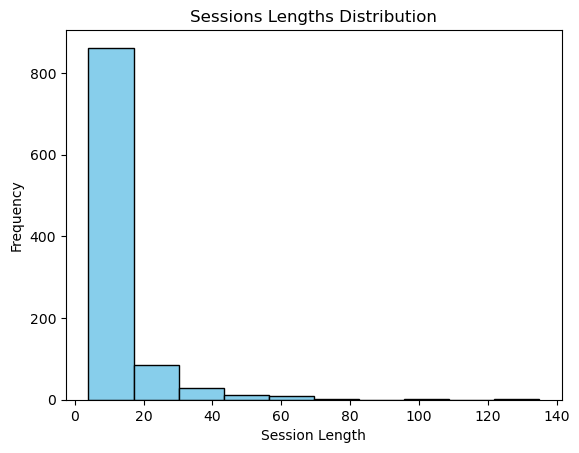

In [23]:
show_histogram(session_lengths, 'Sessions Lengths Distribution', 'Session Length', 'Frequency', bins=10)

In [24]:
sessions_positions = list(map(lambda ch: session_to_positions(ranking, ch[0]["session"]), chunked_data))
sessions_values = list(map(lambda ch: session_to_values(ranking, ch[0]["session"]), chunked_data))

In [25]:
avg_positions = torch.Tensor(list(map(lambda s: sum(s) / len(s), sessions_positions)))
avg_values = torch.Tensor(list(map(lambda s: sum(s) / len(s), sessions_values)))

In [26]:
avg_positions.mean().item(), avg_positions.median().item(), avg_positions.std().item(), avg_positions.max().item(), avg_positions.min().item()

(1184.4971923828125, 531.09375, 1550.4864501953125, 10898.75, 3.25)

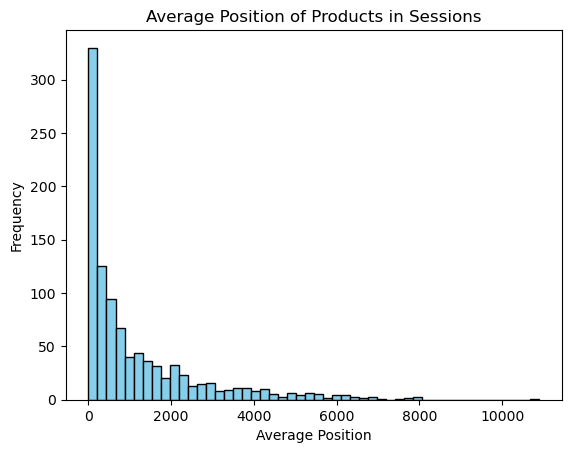

In [27]:
show_histogram(avg_positions, 'Average Position of Products in Sessions', 'Average Position', 'Frequency', bins=50)

In [28]:
avg_values.mean().item(), avg_values.median().item(), avg_values.std().item(), avg_values.max().item(), avg_values.min().item()

(2587.5908203125, 1881.5999755859375, 2513.193359375, 12908.0, 8.5)

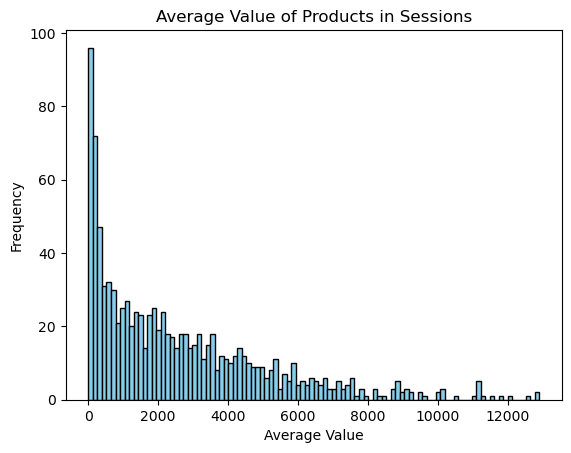

In [29]:
show_histogram(avg_values, 'Average Value of Products in Sessions', 'Average Value', 'Frequency', bins=100)

In [30]:
short_threshold = 7
long_threshold = 20
popular_threshold = 100
unpopular_threshold = 1000
r1 = all_metrics_values(chunked_data, "all data")
r2 = all_metrics_values(chunked_data_modify_session_embeddings, "all data")
r3 = all_metrics_values(filter_chunked_data(chunked_data, lambda ch: len(ch[0]["session"]) < short_threshold), "short s.")
r4 = all_metrics_values(filter_chunked_data(chunked_data_modify_session_embeddings, lambda ch: len(ch[0]["session"]) < short_threshold), "short s.")
r5 = all_metrics_values(filter_chunked_data(chunked_data, lambda ch: len(ch[0]["session"]) >= short_threshold and len(ch[0]["session"]) < long_threshold), "medium l. s.")
r6 = all_metrics_values(filter_chunked_data(chunked_data_modify_session_embeddings, lambda ch: len(ch[0]["session"]) >= short_threshold and len(ch[0]["session"]) < long_threshold), "medium length s.")
r7 = all_metrics_values(filter_chunked_data(chunked_data, lambda ch: len(ch[0]["session"]) >= long_threshold), "long s.")
r8 = all_metrics_values(filter_chunked_data(chunked_data_modify_session_embeddings, lambda ch: len(ch[0]["session"]) >= long_threshold), "long s.")
r9 = all_metrics_values(filter_chunked_data(chunked_data, lambda ch: all(p < popular_threshold for p in session_to_positions(ranking, ch[0]["session"]))), "popular s.")
r10 = all_metrics_values(filter_chunked_data(chunked_data_modify_session_embeddings, lambda ch: all(p < popular_threshold for p in session_to_positions(ranking, ch[0]["session"]))), "popular s.")
r11 = all_metrics_values(filter_chunked_data(chunked_data, lambda ch: all(p > unpopular_threshold for p in session_to_positions(ranking, ch[0]["session"]))), "unpopular s.")
r12 = all_metrics_values(filter_chunked_data(chunked_data_modify_session_embeddings, lambda ch: all(p > unpopular_threshold for p in session_to_positions(ranking, ch[0]["session"]))), "unpopular s.")

# metrics_df = pd.DataFrame([r1])
metrics_df = pd.DataFrame([r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12])
metrics_df

,name,modify_global_embedding,no_of_sessions,deterministic_score,stability_score,common_vertices,average_weight_per_vertex,average_weight_per_vertex_fake,average_weight_per_session,average_weight_per_session_fake,positive_vertices,positive_vertices_fake,positive_sessions,positive_sessions_fake,average_ranking_pos,average_ranking_value,uniqueness,top_5_most_suggested_vertices,top_5_most_suggested_vertices_ranking_positions,top_5_vertices_cumulative_percentage,se_percentage,se_lengths,se_common_vertices_double,se_common_vertices_triple,se_average_weight_per_vertex,se_average_weight_per_vertex_fake,se_average_weight_per_session,se_average_weight_per_session_fake,se_positive_vertices,se_positive_vertices_fake,se_positive_sessions,se_positive_sessions_fake,se_average_ranking_pos,se_average_ranking_value,se_top_5_most_suggested_vertices,se_top_5_most_suggested_vertices_ranking_positions,se_top_5_vertices_cumulative_percentage
0,all data,False,1000,0.13,0.06,0.23,8.422,0.030,94.510,0.334,0.039,0.002,0.097,0.018,7332,438.141,0.607,"[(13719, 0.05), (12898, 0.05), (12365, 0.05), (12894, 0.04), (13722, 0.03)]","[15700, 10794, 4935, 1805, 41]",0.212,0.59,4.14,0.30,0.24,10.822,0.170,88.433,1.390,0.059,0.009,0.071,0.003,7768,554.167,"[(12898, 0.08), (13719, 0.08), (12365, 0.07), (12894, 0.07), (13724, 0.05)]","[10794, 15700, 4935, 1805, 15701]",0.341
1,all data,True,1000,0.41,0.10,0.66,7.713,0.986,92.555,11.837,0.043,0.010,0.114,0.036,7533,426.964,0.612,"[(12365, 0.05), (13719, 0.05), (12898, 0.05), (12894, 0.04), (13722, 0.02)]","[4935, 15700, 10794, 1805, 41]",0.201,0.57,3.93,0.74,0.34,9.772,0.228,87.553,2.042,0.056,0.007,0.089,0.009,8101,442.285,"[(13719, 0.09), (12898, 0.09), (12365, 0.08), (12894, 0.08), (13724, 0.06)]","[15700, 10794, 4935, 1805, 15701]",0.394
2,short s.,False,401,0.09,0.04,0.19,16.298,0.052,80.394,0.254,0.069,0.009,0.102,0.020,7308,510.426,0.636,"[(12365, 0.06), (12898, 0.06), (13719, 0.06), (12894, 0.04), (13722, 0.03)]","[4935, 10794, 15700, 1805, 41]",0.254,0.72,4.37,0.24,0.20,18.042,0.187,88.660,0.918,0.078,0.005,0.076,0.003,7499,689.264,"[(12898, 0.07), (13719, 0.07), (12365, 0.07), (12894, 0.06), (13724, 0.05)]","[10794, 15700, 4935, 1805, 15701]",0.323
3,short s.,True,315,0.39,0.12,0.70,9.717,0.010,52.657,0.054,0.068,0.003,0.121,0.013,7451,427.556,0.679,"[(13719, 0.06), (12894, 0.05), (12898, 0.05), (12365, 0.04), (13722, 0.03)]","[15700, 1805, 10794, 4935, 41]",0.235,0.73,3.90,0.70,0.34,13.334,0.170,71.835,0.919,0.069,0.013,0.109,0.013,7842,478.362,"[(13719, 0.08), (12898, 0.08), (12894, 0.08), (12365, 0.07), (13724, 0.06)]","[15700, 10794, 1805, 4935, 15701]",0.375
4,medium l. s.,False,484,0.16,0.07,0.27,11.240,0.044,120.477,0.475,0.047,0.005,0.097,0.019,7324,413.054,0.690,"[(13719, 0.06), (12898, 0.05), (12365, 0.04), (12894, 0.03), (13722, 0.03)]","[15700, 10794, 4935, 1805, 41]",0.205,0.58,3.97,0.36,0.27,8.799,0.033,89.434,0.334,0.055,0.003,0.068,0.014,7990,451.247,"[(12898, 0.09), (13719, 0.08), (12894, 0.07), (12365, 0.07), (13724, 0.05)]","[10794, 15700, 1805, 4935, 15701]",0.358
5,medium length s.,True,558,0.43,0.10,0.65,8.065,0.165,85.373,1.751,0.051,0.004,0.111,0.025,7556,439.271,0.676,"[(12365, 0.05), (12898, 0.05), (13719, 0.04), (12894, 0.03), (13722, 0.02)]","[4935, 10794, 15700, 1805, 41]",0.199,0.56,4.00,0.75,0.33,8.365,0.319,81.509,3.104,0.058,0.011,0.080,0.019,8224,431.789,"[(13719, 0.1), (12898, 0.09), (12365, 0.08), (12894, 0.08), (13724, 0.06)]","[15700, 10794, 4935, 1805, 15701]",0.407
6,long s.,False,115,0.17,0.08,0.23,0.977,0.002,34.443,0.061,0.013,0.000,0.078,0.017,7450,291.670,0.922,"[(12894, 0.03), (12898, 0.03), (1172, 0.02), (3334, 0.02), (12365, 0.02)]","[1805, 10794, 9188, 2952, 4935]",0.104,0.22,3.32,0.31,0.27,2.285,0.005,71.590,0.157,0.033,0.000,0.040,0.000,8410,135.626,"[(12894, 0.1), (13719, 0.1), (12365, 0.08), (12898, 0.08), (12896, 0.05)]","[1805, 15700, 4935, 10794, 14018]",0.410
7,long s.,True,127,0.39,0.09,0.59,6.459,0.036,223.071,1.244,0.023,0.004,0.110,0.047,7634,371

In [31]:

metrics_df[~metrics_df['modify_global_embedding']]


,name,modify_global_embedding,no_of_sessions,deterministic_score,stability_score,common_vertices,average_weight_per_vertex,average_weight_per_vertex_fake,average_weight_per_session,average_weight_per_session_fake,positive_vertices,positive_vertices_fake,positive_sessions,positive_sessions_fake,average_ranking_pos,average_ranking_value,uniqueness,top_5_most_suggested_vertices,top_5_most_suggested_vertices_ranking_positions,top_5_vertices_cumulative_percentage,se_percentage,se_lengths,se_common_vertices_double,se_common_vertices_triple,se_average_weight_per_vertex,se_average_weight_per_vertex_fake,se_average_weight_per_session,se_average_weight_per_session_fake,se_positive_vertices,se_positive_vertices_fake,se_positive_sessions,se_positive_sessions_fake,se_average_ranking_pos,se_average_ranking_value,se_top_5_most_suggested_vertices,se_top_5_most_suggested_vertices_ranking_positions,se_top_5_vertices_cumulative_percentage
0,all data,False,1000,0.13,0.06,0.23,8.422,0.030,94.510,0.334,0.039,0.002,0.097,0.018,7332,438.141,0.607,"[(13719, 0.05), (12898, 0.05), (12365, 0.05), (12894, 0.04), (13722, 0.03)]","[15700, 10794, 4935, 1805, 41]",0.212,0.59,4.14,0.30,0.24,10.822,0.170,88.433,1.390,0.059,0.009,0.071,0.003,7768,554.167,"[(12898, 0.08), (13719, 0.08), (12365, 0.07), (12894, 0.07), (13724, 0.05)]","[10794, 15700, 4935, 1805, 15701]",0.341
2,short s.,False,401,0.09,0.04,0.19,16.298,0.052,80.394,0.254,0.069,0.009,0.102,0.020,7308,510.426,0.636,"[(12365, 0.06), (12898, 0.06), (13719, 0.06), (12894, 0.04), (13722, 0.03)]","[4935, 10794, 15700, 1805, 41]",0.254,0.72,4.37,0.24,0.20,18.042,0.187,88.660,0.918,0.078,0.005,0.076,0.003,7499,689.264,"[(12898, 0.07), (13719, 0.07), (12365, 0.07), (12894, 0.06), (13724, 0.05)]","[10794, 15700, 4935, 1805, 15701]",0.323
4,medium l. s.,False,484,0.16,0.07,0.27,11.240,0.044,120.477,0.475,0.047,0.005,0.097,0.019,7324,413.054,0.690,"[(13719, 0.06), (12898, 0.05), (12365, 0.04), (12894, 0.03), (13722, 0.03)]","[15700, 10794, 4935, 1805, 41]",0.205,0.58,3.97,0.36,0.27,8.799,0.033,89.434,0.334,0.055,0.003,0.068,0.014,7990,451.247,"[(12898, 0.09), (13719, 0.08), (12894, 0.07), (12365, 0.07), (13724, 0.05)]","[10794, 15700, 1805, 4935, 15701]",0.358
6,long s.,False,115,0.17,0.08,0.23,0.977,0.002,34.443,0.061,0.013,0.000,0.078,0.017,7450,291.670,0.922,"[(12894, 0.03), (12898, 0.03), (1172, 0.02), (3334, 0.02), (12365, 0.02)]","[1805, 10794, 9188, 2952, 4935]",0.104,0.22,3.32,0.31,0.27,2.285,0.005,71.590,0.157,0.033,0.000,0.040,0.000,8410,135.626,"[(12894, 0.1), (13719, 0.1), (12365, 0.08), (12898, 0.08), (12896, 0.05)]","[1805, 15700, 4935, 10794, 14018]",0.410
8,popular s.,False,90,0.04,0.02,0.24,67.182,0.131,431.456,0.844,0.106,0.035,0.122,0.033,6706,781.667,0.222,"[(12898, 0.26), (12365, 0.16), (12894, 0.11), (13719, 0.1), (14988, 0.07)]","[10794, 4935, 1805, 15700, 2186]",0.689,0.98,4.83,0.30,0.26,31.865,1.738,206.259,11.249,0.081,0.010,0.023,0.000,7819,615.820,"[(12898, 0.14), (13719, 0.12), (12365, 0.12), (12894, 0.12), (13724, 0.08)]","[10794, 15700, 4935, 1805, 15701]",0.584
10,unpopular s.,False,105,0.11,0.04,0.18,0.526,0.000,4.190,0.000,0.032,0.000,0.067,0.000,6349,220.419,0.981,"[(12505, 0.03), (219, 0.01), (254, 0.01), (314, 0.01), (320, 0.01)]","[1216, 2158, 2320, 14246, 8875]",0.067,0.50,3.42,0.25,0.14,0.523,0.000,3.685,0.000,0.041,0.000,0.058,0.000,7403,264.521,"[(12505, 0.02), (5264, 0.02), (13722, 0.02), (314, 0.01), (2319, 0.01)]","[1216, 12725, 41, 14246, 7839]",0.079


In [32]:
metrics_df[metrics_df['modify_global_embedding']]


,name,modify_global_embedding,no_of_sessions,deterministic_score,stability_score,common_vertices,average_weight_per_vertex,average_weight_per_vertex_fake,average_weight_per_session,average_weight_per_session_fake,positive_vertices,positive_vertices_fake,positive_sessions,positive_sessions_fake,average_ranking_pos,average_ranking_value,uniqueness,top_5_most_suggested_vertices,top_5_most_suggested_vertices_ranking_positions,top_5_vertices_cumulative_percentage,se_percentage,se_lengths,se_common_vertices_double,se_common_vertices_triple,se_average_weight_per_vertex,se_average_weight_per_vertex_fake,se_average_weight_per_session,se_average_weight_per_session_fake,se_positive_vertices,se_positive_vertices_fake,se_positive_sessions,se_positive_sessions_fake,se_average_ranking_pos,se_average_ranking_value,se_top_5_most_suggested_vertices,se_top_5_most_suggested_vertices_ranking_positions,se_top_5_vertices_cumulative_percentage
1,all data,True,1000,0.41,0.10,0.66,7.713,0.986,92.555,11.837,0.043,0.010,0.114,0.036,7533,426.964,0.612,"[(12365, 0.05), (13719, 0.05), (12898, 0.05), (12894, 0.04), (13722, 0.02)]","[4935, 15700, 10794, 1805, 41]",0.201,0.57,3.93,0.74,0.34,9.772,0.228,87.553,2.042,0.056,0.007,0.089,0.009,8101,442.285,"[(13719, 0.09), (12898, 0.09), (12365, 0.08), (12894, 0.08), (13724, 0.06)]","[15700, 10794, 4935, 1805, 15701]",0.394
3,short s.,True,315,0.39,0.12,0.70,9.717,0.010,52.657,0.054,0.068,0.003,0.121,0.013,7451,427.556,0.679,"[(13719, 0.06), (12894, 0.05), (12898, 0.05), (12365, 0.04), (13722, 0.03)]","[15700, 1805, 10794, 4935, 41]",0.235,0.73,3.90,0.70,0.34,13.334,0.170,71.835,0.919,0.069,0.013,0.109,0.013,7842,478.362,"[(13719, 0.08), (12898, 0.08), (12894, 0.08), (12365, 0.07), (13724, 0.06)]","[15700, 10794, 1805, 4935, 15701]",0.375
5,medium length s.,True,558,0.43,0.10,0.65,8.065,0.165,85.373,1.751,0.051,0.004,0.111,0.025,7556,439.271,0.676,"[(12365, 0.05), (12898, 0.05), (13719, 0.04), (12894, 0.03), (13722, 0.02)]","[4935, 10794, 15700, 1805, 41]",0.199,0.56,4.00,0.75,0.33,8.365,0.319,81.509,3.104,0.058,0.011,0.080,0.019,8224,431.789,"[(13719, 0.1), (12898, 0.09), (12365, 0.08), (12894, 0.08), (13724, 0.06)]","[15700, 10794, 4935, 1805, 15701]",0.407
7,long s.,True,127,0.39,0.09,0.59,6.459,0.036,223.071,1.244,0.023,0.004,0.110,0.047,7634,371.425,0.882,"[(12365, 0.05), (12898, 0.03), (1172, 0.02), (7302, 0.02), (12894, 0.02)]","[4935, 10794, 9188, 5342, 1805]",0.134,0.24,3.52,0.86,0.48,9.785,0.256,286.450,7.495,0.026,0.011,0.032,0.032,8779,280.945,"[(12898, 0.11), (12365, 0.09), (13719, 0.08), (12894, 0.06), (13724, 0.06)]","[10794, 4935, 15700, 1805, 15701]",0.404
9,popular s.,True,82,0.43,0.10,0.87,72.326,0.579,532.744,4.268,0.129,0.022,0.134,0.049,6405,747.927,0.232,"[(12898, 0.2), (12894, 0.18), (12365, 0.16), (13719, 0.12), (14988, 0.06)]","[10794, 1805, 4935, 15700, 2186]",0.720,0.95,5.18,0.79,0.38,27.188,0.350,198.188,2.552,0.071,0.015,0.026,0.000,8208,584.866,"[(12898, 0.14), (13719, 0.14), (12894, 0.13), (12365, 0.12), (13724, 0.1)]","[10794, 15700, 1805, 4935, 15701]",0.626
11,unpopular s.,True,90,0.38,0.09,0.57,0.288,0.001,2.578,0.011,0.021,0.001,0.056,0.011,7258,100.700,0.967,"[(4402, 0.02), (7587, 0.02), (12894, 0.02), (89, 0.01), (131, 0.01)]","[3302, 10658, 1805, 3672, 7285]",0.089,0.48,2.95,0.75,0.29,0.608,0.000,4.606,0.000,0.054,0.000,0.047,0.000,6954,97.091,"[(6407, 0.02), (6717, 0.02), (9313, 0.02), (12505, 0.02), (31, 0.01)]","[6424, 7373, 5463, 1216, 400]",0.071


In [33]:
metrics_df[~metrics_df['modify_global_embedding']][["average_ranking_pos", "average_ranking_value", "uniqueness", "top_5_most_suggested_vertices", "top_5_vertices_cumulative_percentage"]]

,average_ranking_pos,average_ranking_value,uniqueness,top_5_most_suggested_vertices,top_5_vertices_cumulative_percentage
0,7332,438.141,0.607,"[(13719, 0.05), (12898, 0.05), (12365, 0.05), (12894, 0.04), (13722, 0.03)]",0.212
2,7308,510.426,0.636,"[(12365, 0.06), (12898, 0.06), (13719, 0.06), (12894, 0.04), (13722, 0.03)]",0.254
4,7324,413.054,0.690,"[(13719, 0.06), (12898, 0.05), (12365, 0.04), (12894, 0.03), (13722, 0.03)]",0.205
6,7450,291.670,0.922,"[(12894, 0.03), (12898, 0.03), (1172, 0.02), (3334, 0.02), (12365, 0.02)]",0.104
8,6706,781.667,0.222,"[(12898, 0.26), (12365, 0.16), (12894, 0.11), (13719, 0.1), (14988, 0.07)]",0.689
10,6349,220.419,0.981,"[(12505, 0.03), (219, 0.01), (254, 0.01), (314, 0.01), (320, 0.01)]",0.067


In [35]:
relevance = ["name", "average_weight_per_vertex", "average_weight_per_vertex_fake", "average_weight_per_session", "average_weight_per_session_fake", "positive_vertices", "positive_vertices_fake", "positive_sessions", "positive_sessions_fake"]
relevance_se = ["name", "se_average_weight_per_vertex", "se_average_weight_per_vertex_fake", "se_average_weight_per_session", "se_average_weight_per_session_fake", "se_positive_vertices", "se_positive_vertices_fake", "se_positive_sessions", "se_positive_sessions_fake"]
specificity = ["name", "average_ranking_pos", "average_ranking_value", "uniqueness", "top_5_most_suggested_vertices", "top_5_most_suggested_vertices_ranking_positions", "top_5_vertices_cumulative_percentage"]
specificity_se = ["name", "se_average_ranking_pos", "se_average_ranking_value", "uniqueness", "se_top_5_most_suggested_vertices", "se_top_5_most_suggested_vertices_ranking_positions", "se_top_5_vertices_cumulative_percentage"]
stability = ["name", "deterministic_score", "stability_score", "common_vertices"]
stability_se = ["name", "se_common_vertices_double", "se_common_vertices_triple"]
metrics_categories = {
    "relevance": relevance,
    "specificity": specificity,
    "stability": stability,
    "relevance_se": relevance_se,
    "specificity_se": specificity_se,
    "stability_se": stability_se
}

/Ziob/wsniady/TAGNN_explainer/TAGNN/analysis_utils.py:114: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


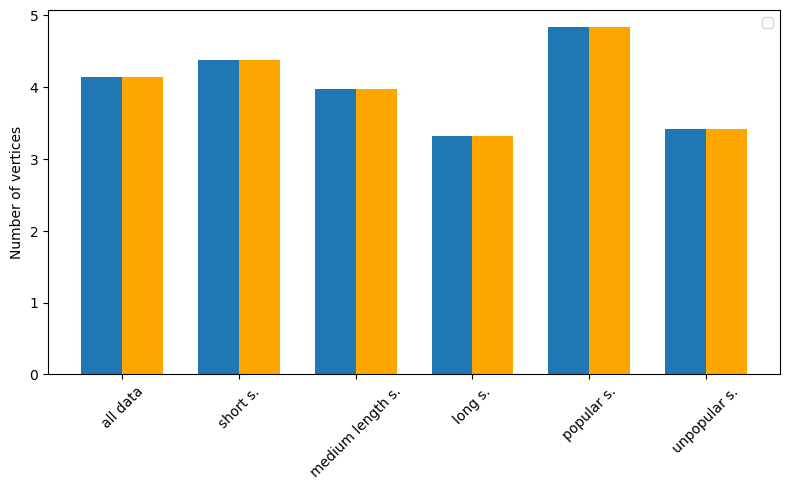

In [36]:
labels = metrics_df[metrics_df['modify_global_embedding']]["name"]
se_lengths_false = metrics_df[~metrics_df['modify_global_embedding']]["se_lengths"] 
se_lengths_true = metrics_df[~metrics_df['modify_global_embedding']]["se_lengths"]  
show_double_bar_chart(labels, se_lengths_false, se_lengths_true, "Number of vertices")

/Ziob/wsniady/TAGNN_explainer/TAGNN/analysis_utils.py:114: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


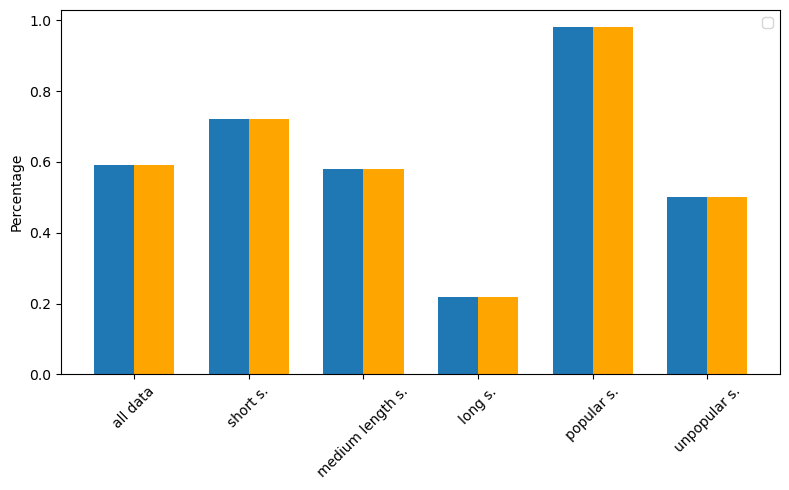

In [37]:
se_percentage_false = metrics_df[~metrics_df['modify_global_embedding']]["se_percentage"] 
se_percentage_true = metrics_df[~metrics_df['modify_global_embedding']]["se_percentage"]  
show_double_bar_chart(labels, se_percentage_false, se_percentage_true, "Percentage")